We will start by importing the libraries that will be used throughout Q2.

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
import torch
import math

We also seed the randomness to ensure reproducibility.

In [85]:
torch.manual_seed(0)

The next step is to write a function that will generate data given the desired label and number of samples.

In [86]:
def generate_data(label, n_samples=10000):
    r = np.random.normal(0, 1, n_samples) # Generate radiuses
    t = np.random.uniform(0, 2*np.pi, n_samples) # Generate angles
    x1 = (r + 5 * label) * np.cos(t)
    x2 = (r + 5 * label) * np.sin(t)
    return np.column_stack([x1, x2, label * np.ones((n_samples, 1))]) # Stack the 2 features and the labels

We will also define a function that plots the data given a particular color & marker.

In [87]:
def plot_data(data, label, color='red', marker ='marker'):
    plt.scatter(data[:, 0], data[:, 1], c=color, label=label, edgecolors='none', marker=marker, alpha=1.0)

We can now move on to generate and plot the dataset. Since the class distribution was not mentioned in the PDF, we will assume a 50/50 repartition between the 2 labels.

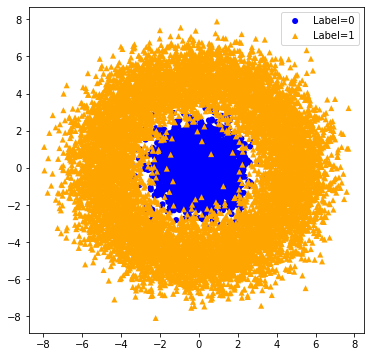

In [88]:
# Generate 10000 points for each label
data_0 = generate_data(0)
data_1 = generate_data(1)

# Merge both labels into 1 dataset
dataset = np.row_stack([np.column_stack([data_0, np.zeros((10000, 1))]), np.column_stack([data_1, np.ones((10000, 1))])])

# Shuffle the data
np.random.shuffle(dataset)

# Plot the data
plt.figure(figsize=(6, 6))
plot_data(dataset[dataset[:, 2] == 0][:, :2], 'Label=0', 'blue', marker='o')
plot_data(dataset[dataset[:, 2] == 1][:, :2], 'Label=1', 'orange', marker='^')
plt.legend()

The next step is now to convert the numpy array to a pytorch tensor dataset, before splitting that data between training and validation sets. It is to be noted that, since, as per the directions of the responsible TA, we don't need to fine-tune, the validation set will act as more of a testing set since we only use it once to validate our choice of hyperparameters.

In [89]:
# creating our dataset using PyTorch
dataset = torch.utils.data.TensorDataset(
            torch.Tensor(dataset[:, :2]), torch.LongTensor(dataset[:, 2].astype(int)))

# Split data into training and validation (80/20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

As requested by the assignment prompt, we can now proceed to plot the validation data as we did for the full dataset.

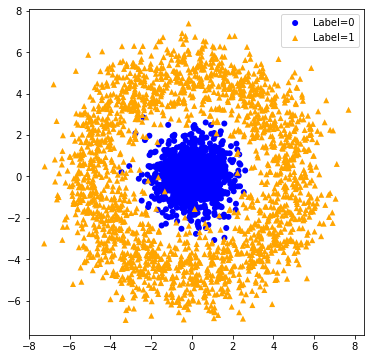

In [90]:
# Extract validation numpy elements from the initial dataset
val_features = dataset[val_dataset.indices][0].numpy()
val_labels = dataset[val_dataset.indices][1].numpy()

# Plot the validation data
plt.figure(figsize=(6, 6))
plot_data(val_features[val_labels == 0], 'Label=0', 'blue', marker='o')
plot_data(val_features[val_labels == 1], 'Label=1', 'orange', marker='^')
plt.legend()
plt.savefig("validation_data.png")

We can now proceed to define the stochastic minibatch gradient descent hyperparameters, and create data loaders using them. Since the dataset is mathematically generated, we believe that fine-tuning the gradient descent hyperparameters is not necessary as long as the learning rate is small enough to not overshoot, as well as the number of epochs is large enough to converge. Furthermore, we define a minibatch size of 32 to improve training speed while not affecting the final accuracy too much. Neural networks are specifically made to learn any mathematical function with ease, which is why it won't need much tuning to achieve good results here. Finally, we choose the number of hidden units to be the maximum of 30, since having more hidden units means that the network becomes more flexible at the risk of overfitting more. Since we are also tracking the validation / testing set error here, we will be able to know whether we are overfitting in case the validation error starts increasing at some point, which helps alleviate that concern.

In [91]:
# Hyperparameters
num_epochs = 50
batch_size = 32
learning_rate = 0.005
n_hidden = 30

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                             batch_size=batch_size,
                                                shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                                batch_size=batch_size,
                                                shuffle=False)

The next step is then to define a 1-layer neural network class using PyTorch, as per the assignment instructions. Since we are allowed a maximum of 30 hidden units, we decide to use all 30 since it is still a lightweight 1 layer network, and more hidden units means more flexibility in learning the underlying function. Furthermore, we decided to choose the sigmoid activation since we are doing binary classification, paired with binary cross-entropy for the loss function because it works well for that same application.

In [92]:
class Net(torch.nn.Module):

    # Constructor initializes the network
    def __init__(self, n_feature, n_hidden):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.out = torch.nn.Linear(n_hidden, 1)   # output layer

    # Forward pass
    def forward(self, x):
        x = self.hidden(x)
        x = torch.relu(x) # Hidden layer activation
        x = self.out(x)
        x = torch.sigmoid(x) # Output layer activation
        return x

We now proceed to initializing our MLP and printing its architecture to ensure everything looks good.

In [93]:
net = Net(n_feature=2, n_hidden=n_hidden)     # define the network
print(net)  # net architecture

Net(
  (hidden): Linear(in_features=2, out_features=30, bias=True)
  (out): Linear(in_features=30, out_features=1, bias=True)
)


Next up, we define the BCE loss function.

In [94]:
# Loss function
criterion = torch.nn.BCELoss()

# Optimizer for the parameters
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

# To hold the losses & accuracies throughout epochs
train_loss = []
val_loss = []
train_acc = []
val_acc = []

We the proceed to move the network to the GPU before training it through backpropagation.

Using the following device: cuda:0
Epoch [1/50], Validation Loss: 0.3394, Validation Accuracy: 94.53%,    Training Loss: 0.4393, Training Accuracy: 87.10%
Epoch [2/50], Validation Loss: 0.2271, Validation Accuracy: 97.78%,    Training Loss: 0.2741, Training Accuracy: 97.13%
Epoch [3/50], Validation Loss: 0.1645, Validation Accuracy: 98.38%,    Training Loss: 0.1883, Training Accuracy: 98.67%
Epoch [4/50], Validation Loss: 0.1278, Validation Accuracy: 98.70%,    Training Loss: 0.1394, Training Accuracy: 98.96%
Epoch [5/50], Validation Loss: 0.1050, Validation Accuracy: 98.75%,    Training Loss: 0.1100, Training Accuracy: 99.03%
Epoch [6/50], Validation Loss: 0.0901, Validation Accuracy: 98.72%,    Training Loss: 0.0912, Training Accuracy: 99.12%
Epoch [7/50], Validation Loss: 0.0796, Validation Accuracy: 98.75%,    Training Loss: 0.0785, Training Accuracy: 99.16%
Epoch [8/50], Validation Loss: 0.0721, Validation Accuracy: 98.78%,    Training Loss: 0.0695, Training Accuracy: 99.15%
Epoch

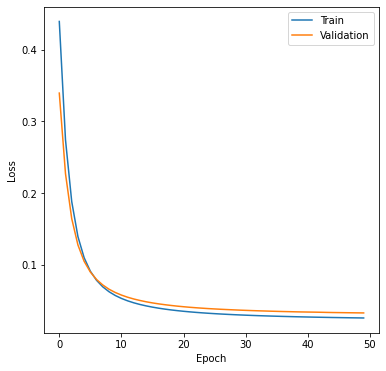

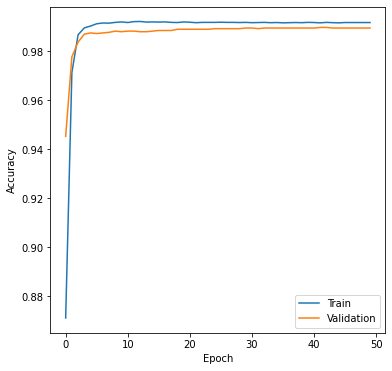

In [95]:
# Extract GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using the following device: {device}")

# Move model to GPU (If available again)
net.to(device)

# Train the model
for epoch in range(num_epochs):

    # Set the mode to training
    net.train()

    # Initialize the epoch losses & accuracies
    train_loss_epoch = 0
    train_acc_epoch = 0
    val_loss_epoch = 0
    val_acc_epoch = 0

    # Iterate through the data batch by batch
    for data, labels in train_loader:
        
        # Reset the gradients for the iteration
        optimizer.zero_grad()
        
        # Move the batch to the GPU if available
        data = data.to(device)
        labels = labels.to(device)

        # Perform a forward pass (__call__ makes a call to forward)
        outputs = net(data)

        # Resize to add the 1 dimension to labels
        labels = labels.view(-1,1)
        loss = criterion(outputs.float(), labels.float())

        # Accumulate the loss for the epoch
        train_loss_epoch += loss.item()

        # Accumulate the accuracy for the epoch
        predicted = (outputs > 0.5).float()
        train_acc_epoch += (predicted == labels).sum().item()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

    # Average out over all  iterations for the loss & all points for the accuracy
    train_loss_epoch /= len(train_loader)
    train_acc_epoch /= len(train_dataset)

    # Append to the arrays defined at the start
    train_loss.append(train_loss_epoch)
    train_acc.append(train_acc_epoch)

    # Put the model in validation mode 
    net.eval()

    # Deactivate gradient calculations during the evaluation
    with torch.no_grad():

        # Iterate through the data, batch by batch
        for data, labels in val_loader:
            
            # Place the minibatch on GPU
            data = data.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = net(data)

            # Compute the loss
            labels = labels.view(-1,1)
            loss = criterion(outputs.float(), labels.float())

            # Accumulate the loss and accuracies
            val_loss_epoch += loss.item()
            predicted = (outputs > 0.5).float()
            val_acc_epoch += (predicted == labels).sum().item()

    # Average out over all  iterations for the loss & all points for the accuracy
    val_loss_epoch /= len(val_loader)
    val_acc_epoch /= len(val_dataset)
    val_loss.append(val_loss_epoch)
    val_acc.append(val_acc_epoch)

    # Print losses and accuracies
    print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%,\
    Training Loss: {:.4f}, Training Accuracy: {:.2f}%'
            .format(epoch+1, num_epochs, val_loss_epoch, val_acc_epoch*100, \
                    train_loss_epoch, train_acc_epoch*100))

# Plot loss as a function of iterations
plt.figure(figsize=(6, 6))
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy as a function of iterations
plt.figure(figsize=(6, 6))
plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Save the figures
plt.savefig("metrics.png")

The resulting accuracies of slightly above 99% make sense, especially since the generated data plot showed that some orange outliers were superposed to the blue dataset, making it impossible for the model to distinguish those. Furthermore, we can see that the model converges, proving that 50 epochs was indeed enough.

Next up we move on to drawing the lines representing the neuron activation thresholds for the ReLU activation functions of the hidden layer.

In [96]:
# Get the data from classes 0 and 1 in the validation set
class0 = val_features[val_labels == 0]
class1 = val_features[val_labels == 1]

The next step is to extract the model parameters (Weights and biases).

In [97]:
# Given parameters, unwraps its value into a numpy array
get_values = lambda x: x.cpu().data.numpy()

# All network parameters (Iterator)
param_gen = net.parameters()
weights = get_values(next(param_gen)) # First call to next retrieves the weights that lead to the hidden layer
biases = get_values(next(param_gen)).reshape(-1, 1) # Second call to next retrieves the bias term that leads to the hidden layer
weights_and_biases = np.concatenate([weights, biases], axis=1) # Concatenate the weights & biases to get a n_hiddenx3 matrix (The last column is the biases)
                                                               # Doing W@x.T returns the values of the hidden units assuming we add a 1 as the last feature in x

We can now solve for the threshold, unit per unit. Knowing that a row (element) of weights_and_biases represents a single hidden units weights & biases vector $\vec{w} = [w1, w2, b]$, we can set the following equation at the threshold:
$$x1.w1 + x2.w2 + b = 0$$
We can then consider the two following special points:
- For x1 = -7, we get that x2 = $\frac{-b + 7.w1}{w2}$
- For x1 = +7, we get that x2 = $\frac{-b - 7.w1}{w2}$
We can then use the points (-7, $\frac{-b + 7.w1}{w2}$) and (7, $\frac{-b - 7.w1}{w2}$) to plot the threshold of the neuron.

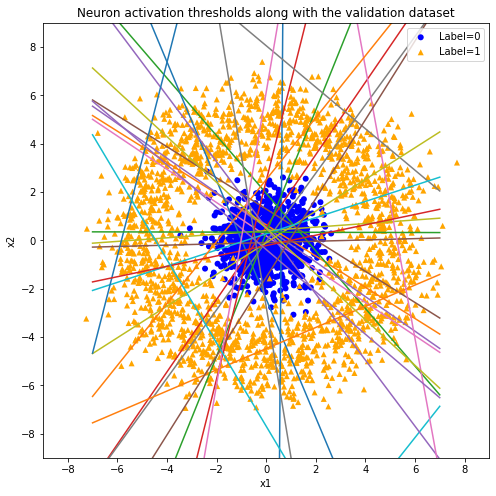

In [98]:
point_pairs = []

# Compute the pairs of points that'll be used to plot each respective threshold
for params in weights_and_biases: 
    point_pairs.append(((-7, (-params[2] + (params[0]*7))/params[1]), (7 ,(-params[2]-(params[0]*7))/params[1])))

# Make a scatter plot of the validation data
plt.figure(figsize=(8,8))
plot_data(class0, "Label=0", color='blue', marker ='o')
plot_data(class1, "Label=1", color='orange', marker ='^')

# Iterate through the pairs of points
for point_pair in point_pairs:
    x1_values = [point_pair[0][0], point_pair[1][0]] # x-axis values
    x2_values = [point_pair[0][1], point_pair[1][1]] # y-axis values
    plt.plot(x1_values, x2_values)

# Label everything
plt.xlabel('x1')
plt.ylabel('x2') 

# Set limits to avoid stretching everything
plt.xlim(-9, 9)
plt.ylim(-9, 9)

# Title & Legend
plt.title("Neuron activation thresholds along with the validation dataset")
plt.legend(loc="best")
plt.savefig("neuron_activations.png")